In [177]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [178]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [179]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, inspect, func

In [180]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///../Resources/hawaii.sqlite")

In [181]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(autoload_with=engine)

In [182]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [183]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [184]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [185]:
inspector = inspect(engine)
columns = inspector.get_columns('Measurement')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [186]:
inspector = inspect(engine)
columns = inspector.get_columns('Station')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [187]:
# Find the most recent date in the data set.
session.query(Measurement.date).order_by(Measurement.date.desc()).first()

('2017-08-23',)

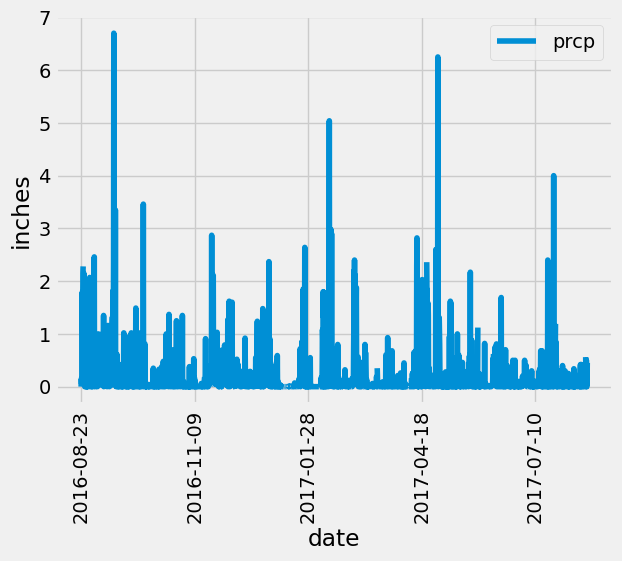

In [188]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
precipitation_most_recent = session.query(Measurement.date, Measurement.prcp).\
                            order_by(Measurement.date.desc()).all()
precipitation_most_recent

# Calculate the date one year from the last date in data set.
one_year_ago = dt.date(2017,8,23) - dt.timedelta(days=366)
str(one_year_ago)

# Perform a query to retrieve the data and precipitation scores
scores = session.query(Measurement.date, Measurement.prcp).\
         filter(Measurement.date>one_year_ago).\
         order_by(Measurement.date).all()
scores

# Save the query results as a Pandas DataFrame and set the index to the date column
# Sort the dataframe by date
df=pd.DataFrame(scores)
df=df.set_index('date')
df=df.sort_index()
df.head()

# Use Pandas Plotting with Matplotlib to plot the data
df.plot(rot=90)
plt.ylabel('inches')
plt.show()

In [189]:
# Use Pandas to calcualte the summary statistics for the precipitation data
df.describe()

,prcp
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [190]:
# Design a query to calculate the total number stations in the dataset
session.query(Station.id).count()

9

In [191]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.
most_active_stations = session.query(Measurement.station, func.count(Measurement.station)).\
                       group_by(Measurement.station).\
                       order_by(func.count(Measurement.station).desc()).all()
most_active_stations 

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [192]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
sel = [Measurement.station,
       func.min(Measurement.tobs),
       func.max(Measurement.tobs),
       func.avg(Measurement.tobs)]

calculation = session.query(*sel).\
              filter(Measurement.station == 'USC00519281').\
              group_by(Measurement.station).\
              order_by(Measurement.station).all()
calculation

[('USC00519281', 54.0, 85.0, 71.66378066378067)]

<AxesSubplot:ylabel='Frequency'>

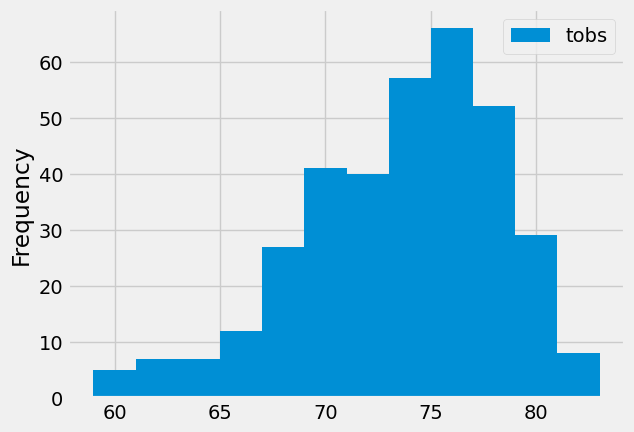

In [193]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
observation = session.query(Measurement.date, Measurement.tobs).\
                        filter(Measurement.date >= "2016-08-24").\
                        filter(Measurement.date <= "2017-08-23").\
                        filter(Measurement.station == most_active_stations [0][0]).all()
observation_df = pd.DataFrame(observation)
observation_df.plot.hist(bins=12)

# Close session

In [194]:
# Close Session
session.close()